# Ensemble Models and Outlook

In the past chapters, several common machine learning algorithms were introduced. They come with different strengths and weaknesses. And, although the code execution always looks very similar, they all require different parameters and adjustments.

Before we move on to the next topic, let us introduce a very generally applicable trick in machine learning: **ensemble learning**. 

Ensemble learning is a method where multiple models, often called "weak learners," are trained and combined to solve the same problem. The key idea is that by combining multiple models, we can achieve better performance than any single model alone. This idea is simple, yet in practice, ensemble models are surprisingly effective. There are two main types of ensemble methods: bagging and boosting.

We will first look at the general idea behind bagging and later apply some common strategies to the data from the last chapter on predicting obesity levels.

## More "weak learners" make a stronger model

For illustrative purposes, we best start with two-dimensional data. The following dummy data contains data points from two classes and follows a spiral pattern.

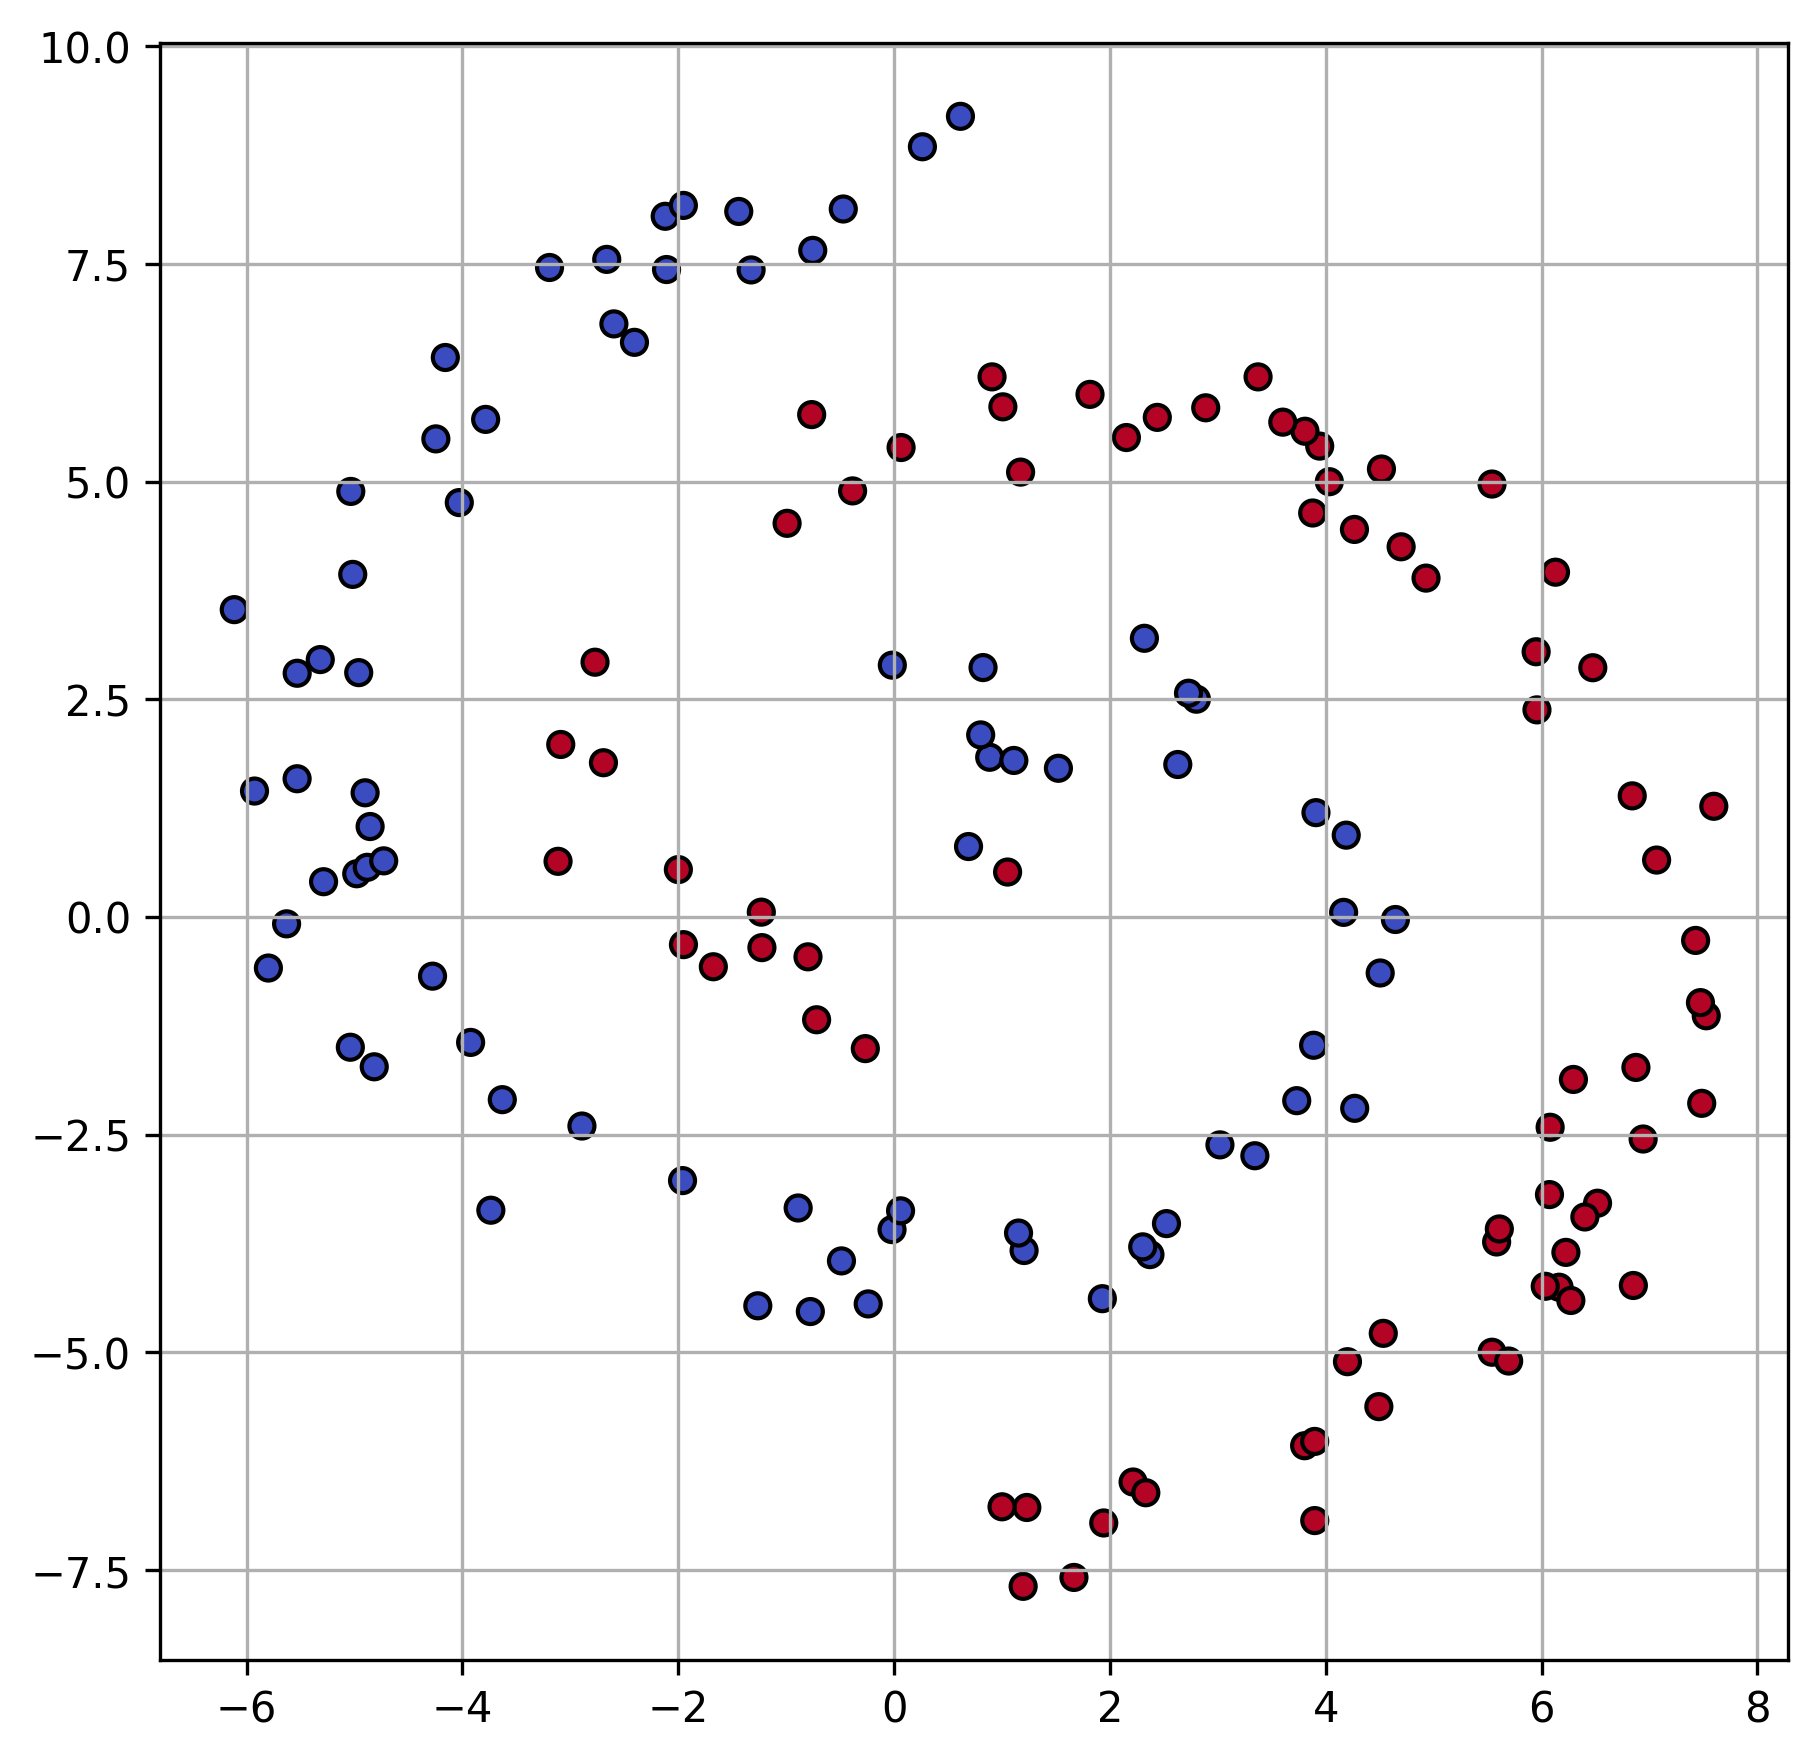

In [109]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.ensemble import BaggingClassifier

NUM_POINTS = 150

def create_spiral_data(n_points,
                       degree=450,
                       noise=1.5,
                       seed=0):
    """Generate 2D spiral data.
    """
    # Initiate Numpy Random Generator (with seed)
    rng = np.random.default_rng(seed)

    # Class 1 points
    n = np.sqrt(rng.random(n_points // 2)) * degree * (2 * np.pi) / 360
    d1x = -np.cos(n) * n + rng.random(n_points // 2) * noise
    d1y = np.sin(n) * n + rng.random(n_points // 2) * noise
    x1 = np.vstack((d1x, d1y)).T

    # Class 2 points
    n = np.sqrt(rng.random(n_points // 2)) * degree * (2 * np.pi) / 360
    d2x = np.cos(n) * n + rng.random(n_points // 2) * noise
    d2y = -np.sin(n) * n + rng.random(n_points // 2) * noise
    x2 = np.vstack((d2x, d2y)).T

    X = np.vstack((x1, x2))
    y = np.hstack((np.zeros(n_points // 2), np.ones(n_points // 2)))
    return X, y

# Create spiral data
X, y = create_spiral_data(NUM_POINTS)

fig, ax = plt.subplots(figsize=(7, 7), dpi=300)
ax.scatter(X[:, 0], X[:, 1], c=y, cmap='coolwarm', edgecolor='k')
ax.grid(True)

A decision tree can handle such data, but the highly non-linear arrangement of the data points makes it slightly cumbersome for such a model. The decision tree ({numref}`ch_decision_trees`) learns decision boundaries along the x- and y-axis, and the shape of a spiral cannot be approximated very well with only a few such binary decisions.

Let us train two decision trees, one with small `max_depth`, and one without any depth restrictions:

In [ ]:
from sklearn.tree import DecisionTreeClassifier

depth1, depth2 = 4, None
tree1 = DecisionTreeClassifier(max_depth=depth1,
                              random_state=0)
tree2 = DecisionTreeClassifier(max_depth=depth2,
                              random_state=0)
# Train the decision trees
tree1.fit(X, y)
tree2.fit(X, y)

We can have both decision trees making predictions on a regular x-y grid of points to display which regions will receive the label 0 (blue) or 1 (red).

In [ ]:
# Create a grid for plotting decision boundaries
min_x = np.floor(X[:, 0].min())
max_x = np.ceil(X[:, 0].max())
min_y = np.floor(X[:, 1].min())
max_y = np.ceil(X[:, 1].max())
xx, yy = np.meshgrid(np.linspace(min_x, max_x, 400),
                     np.linspace(min_y, max_y, 400))
grid = np.c_[xx.ravel(), yy.ravel()]

# Make predictions on entire grid
Z1 = tree1.predict(grid).reshape(xx.shape)
Z2 = tree2.predict(grid).reshape(xx.shape)

fig, axes = plt.subplots(1, 3, figsize=(18, 6), dpi=300)
axes[0].scatter(X[:, 0], X[:, 1], c=y, cmap='coolwarm', edgecolor='k')
axes[1].contourf(xx, yy, Z1, alpha=0.3, cmap='coolwarm')
axes[1].scatter(X[:, 0], X[:, 1], c=y, cmap='coolwarm', edgecolor='k')
axes[1].set_title(f"Tree with max_depth {depth1}")
axes[2].contourf(xx, yy, Z2, alpha=0.3, cmap='coolwarm')
axes[2].scatter(X[:, 0], X[:, 1], c=y, cmap='coolwarm', edgecolor='k')
axes[2].set_title(f"Tree with max_depth {depth2}")

As expected, the decision tree with low depth is not capable of modeling the spiral shape of the data very well. This is also called **underfitting**. On the other hand, the tree with unrestricted depth will come with the problem of **overfitting**.

Finding a good sweet spot between under- and over-fittung can be difficult for decision trees. It is usually much more effective to rather combine many trees to form an **ensemble model**. Two key concepts for training an ensemble model are: **bagging** and **boosting.

## Bagging (Bootstrap Aggregating)

Bagging is a technique that involves training multiple models on different subsets of the training data and then combining their predictions. Each subset is created by randomly sampling the training data with replacement (bootstrap sampling). The final prediction is usually obtained by averaging the predictions (for regression) or taking a majority vote (for classification).

```{figure} ../images/fig_ensemble_bagging.png
:name: fig_ensemble_bagging

In the bagging approach, the training data is randomly sampled (usually with replacement) $n$ times to then train $n$ models (**A**).
During prediction, the output of all $n$ models is counted and the final predictions is defined by voting (**B**).
```

The most common example of such an ensemble model is the **Random Forest**.

### Many Trees are a Forest: Random Forest

Random Forest is an ensemble method that combines multiple decision trees using bagging and random feature selection. Each tree is trained on a different bootstrap sample of the data, and a random subset of features is used for splitting nodes. The final prediction is made by averaging the predictions of all individual trees (for regression) or by majority voting (for classification).

To better understand how (and why) this works, we can create our own simple version of such a bagging algorithm:

In [ ]:
# Combine all trees
class SimpleBagging:
    def __init__(self, trees):
        self.trees = trees

    def predict_proba(self, x):
        predictions = np.array([t.predict(x) for t in self.trees])
        return np.mean(predictions, axis=0)

Let us now train 15 decision trees and combine their result in the end.

Please try the following code also with `BOOTSTRAP = False` and see if you understand what happens.

In [ ]:
MAX_DEPTH = 5
BOOTSTRAP = True

# Train 15 decision trees
trees = []
rng = np.random.default_rng(seed=0)
for _ in range(15):
    if BOOTSTRAP:
        idx = rng.choice(np.arange(NUM_POINTS), NUM_POINTS)
    else:
        idx = np.arange(NUM_POINTS)
    X_bootstrap = X[idx]
    y_bootstrap = y[idx]
    tree = DecisionTreeClassifier(max_depth=MAX_DEPTH, random_state=0)
    trees.append(tree.fit(X_bootstrap, y_bootstrap))

# Combine the trees
bagging_clf = SimpleBagging(trees)

We can again use the grid of x-y points to show the decision boundaries of all 15 trees as well as the ensemble model:

In [ ]:
# Plot decision boundaries of individual trees
fig, axs = plt.subplots(4, 4, figsize=(16, 16), dpi=300)
for i, clf in enumerate(trees):
    ax = axs[i // 4, i % 4]
    Z = clf.predict(grid).reshape(xx.shape)
    ax.contourf(xx, yy, Z, alpha=0.3, cmap='coolwarm')
    ax.scatter(X[:, 0], X[:, 1], c=y, cmap='coolwarm', edgecolor='k')
    ax.set_title(f'Tree {i+1}')

# Plot decision boundary of Bagging classifier
ax = axs[3, 3]
Z = bagging_clf.predict_proba(grid).reshape(xx.shape)
ax.contourf(xx, yy, Z, alpha=0.3, cmap='coolwarm')
ax.scatter(X[:, 0], X[:, 1], c=y, cmap='coolwarm', edgecolor='k')
ax.set_title('Bagging Result')

plt.tight_layout()
plt.show()

The individual decision trees were trained with different subsets of our data (for `BOOTSTRAP = True`). As a consequence, they all learned different decision boundaries, none of them being very good overall due to the limited depth of each tree.

The ensemble model, however, generally performs much better. It also allows us to gain more than just a binary class prediction: we can get the fraction of trees voting for or against a certain class which can give us a sense of uncertainty of the model prediction. In practice, this is often used to further rate or filter model predictions.

## Use-case: Obesity-Level Prediction
Moving away from the illustrative two dimensional toy data, we can apply the same idea to the data set from the last chapter to predict obesity levels.

In [5]:
import os
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sb

In [6]:
filename = "../datasets/obesity_dataset.csv"
data = pd.read_csv(filename)

mask = data.describe(include="all").loc["unique"] == 2
binary_columns = data.columns[mask]
data[binary_columns] = data[binary_columns].replace({'no': 0, 'yes': 1})

y = data.NObeyesdad
X = data.drop(["NObeyesdad"], axis=1)

X = pd.get_dummies(X) #, prefix='', prefix_sep='')
X = X.drop(["Gender_Male"], axis=1)  # not necessary, because here it is either Male or Female
X.head()

,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,SMOKE,CH2O,SCC,...,CAEC_no,CALC_Always,CALC_Frequently,CALC_Sometimes,CALC_no,MTRANS_Automobile,MTRANS_Bike,MTRANS_Motorbike,MTRANS_Public_Transportation,MTRANS_Walking
0,21.0,1.62,64.0,1,0,2.0,3.0,0,2.0,0,...,False,False,False,False,True,False,False,False,True,False
1,21.0,1.52,56.0,1,0,3.0,3.0,1,3.0,1,...,False,False,False,True,False,False,False,False,True,False
2,23.0,1.80,77.0,1,0,2.0,3.0,0,2.0,0,...,False,False,True,False,False,False,False,False,True,False
3,27.0,1.80,87.0,0,0,3.0,3.0,0,2.0,0,...,False,False,True,False,False,False,False,False,False,True
4,22.0,1.78,89.8,0,0,2.0,1.0,0,2.0,0,...,False,False,False,True,False,False,False,False,True,False


In [7]:
from sklearn.model_selection import train_test_split

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

### Single Decision Tree
Let's start again with a single decision tree, here with a set max_depth.
As we saw in the last chapter, such a model works OK-ish on this dataset.

In [22]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

# Initialize base classifier
tree = DecisionTreeClassifier(max_depth=6)
tree.fit(X_train, y_train)

# Make predictions
y_pred = tree.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy of Decision Tree Classifier: {accuracy:.2f}')

Accuracy of Decision Tree Classifier: 0.86


We do not have to build our own class for combining multiple decision trees as we did above with the spiral example. We can simply implement this via the Scikit-Learn `BaggingClassifier` class:

In [23]:
from sklearn.ensemble import BaggingClassifier

# Initialize base classifier
base_clf = DecisionTreeClassifier(max_depth=6)

# Initialize bagging classifier
bagging_clf = BaggingClassifier(estimator=base_clf, n_estimators=50, random_state=42)

# Train the bagging classifier
bagging_clf.fit(X_train, y_train)

# Make predictions
y_pred = bagging_clf.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy of Bagging Classifier: {accuracy:.2f}')

Accuracy of Bagging Classifier: 0.89


However, the **Random Forest** is famous enough to be implemented already in Scikit Learn:

In [26]:
from sklearn.ensemble import RandomForestClassifier

# Initialize Random Forest classifier
rf_clf = RandomForestClassifier(max_depth=6, n_estimators=50, random_state=42)

# Train the Random Forest classifier
rf_clf.fit(X_train, y_train)

# Make predictions
y_pred = rf_clf.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy of Random Forest Classifier: {accuracy:.2f}')


Accuracy of Random Forest Classifier: 0.89


### Boosting

Boosting is another ensemble technique that focuses on training models sequentially. Each new model attempts to correct the errors made by the previous ones. This way, the models "boost" the performance by focusing more on the difficult cases.

In [24]:
from sklearn.ensemble import AdaBoostClassifier

# Initialize base classifier
base_clf = DecisionTreeClassifier(max_depth=6)

# Initialize AdaBoost classifier
ada_clf = AdaBoostClassifier(estimator=base_clf, n_estimators=50, random_state=42)

# Train the AdaBoost classifier
ada_clf.fit(X_train, y_train)

# Make predictions
y_pred = ada_clf.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy of AdaBoost Classifier: {accuracy:.2f}')


Accuracy of AdaBoost Classifier: 0.96


With some more parameters searches we can probably improve even a little more... (try it out yourself!).

In [37]:
base_clf = DecisionTreeClassifier(max_depth=10)
ada_clf = AdaBoostClassifier(estimator=base_clf, n_estimators=200, random_state=42)
ada_clf.fit(X_train, y_train)

y_pred = ada_clf.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy of AdaBoost Classifier: {accuracy:.2f}')

Accuracy of AdaBoost Classifier: 0.97


The accuracy looks promising, but let's better also check the confusion matrix.

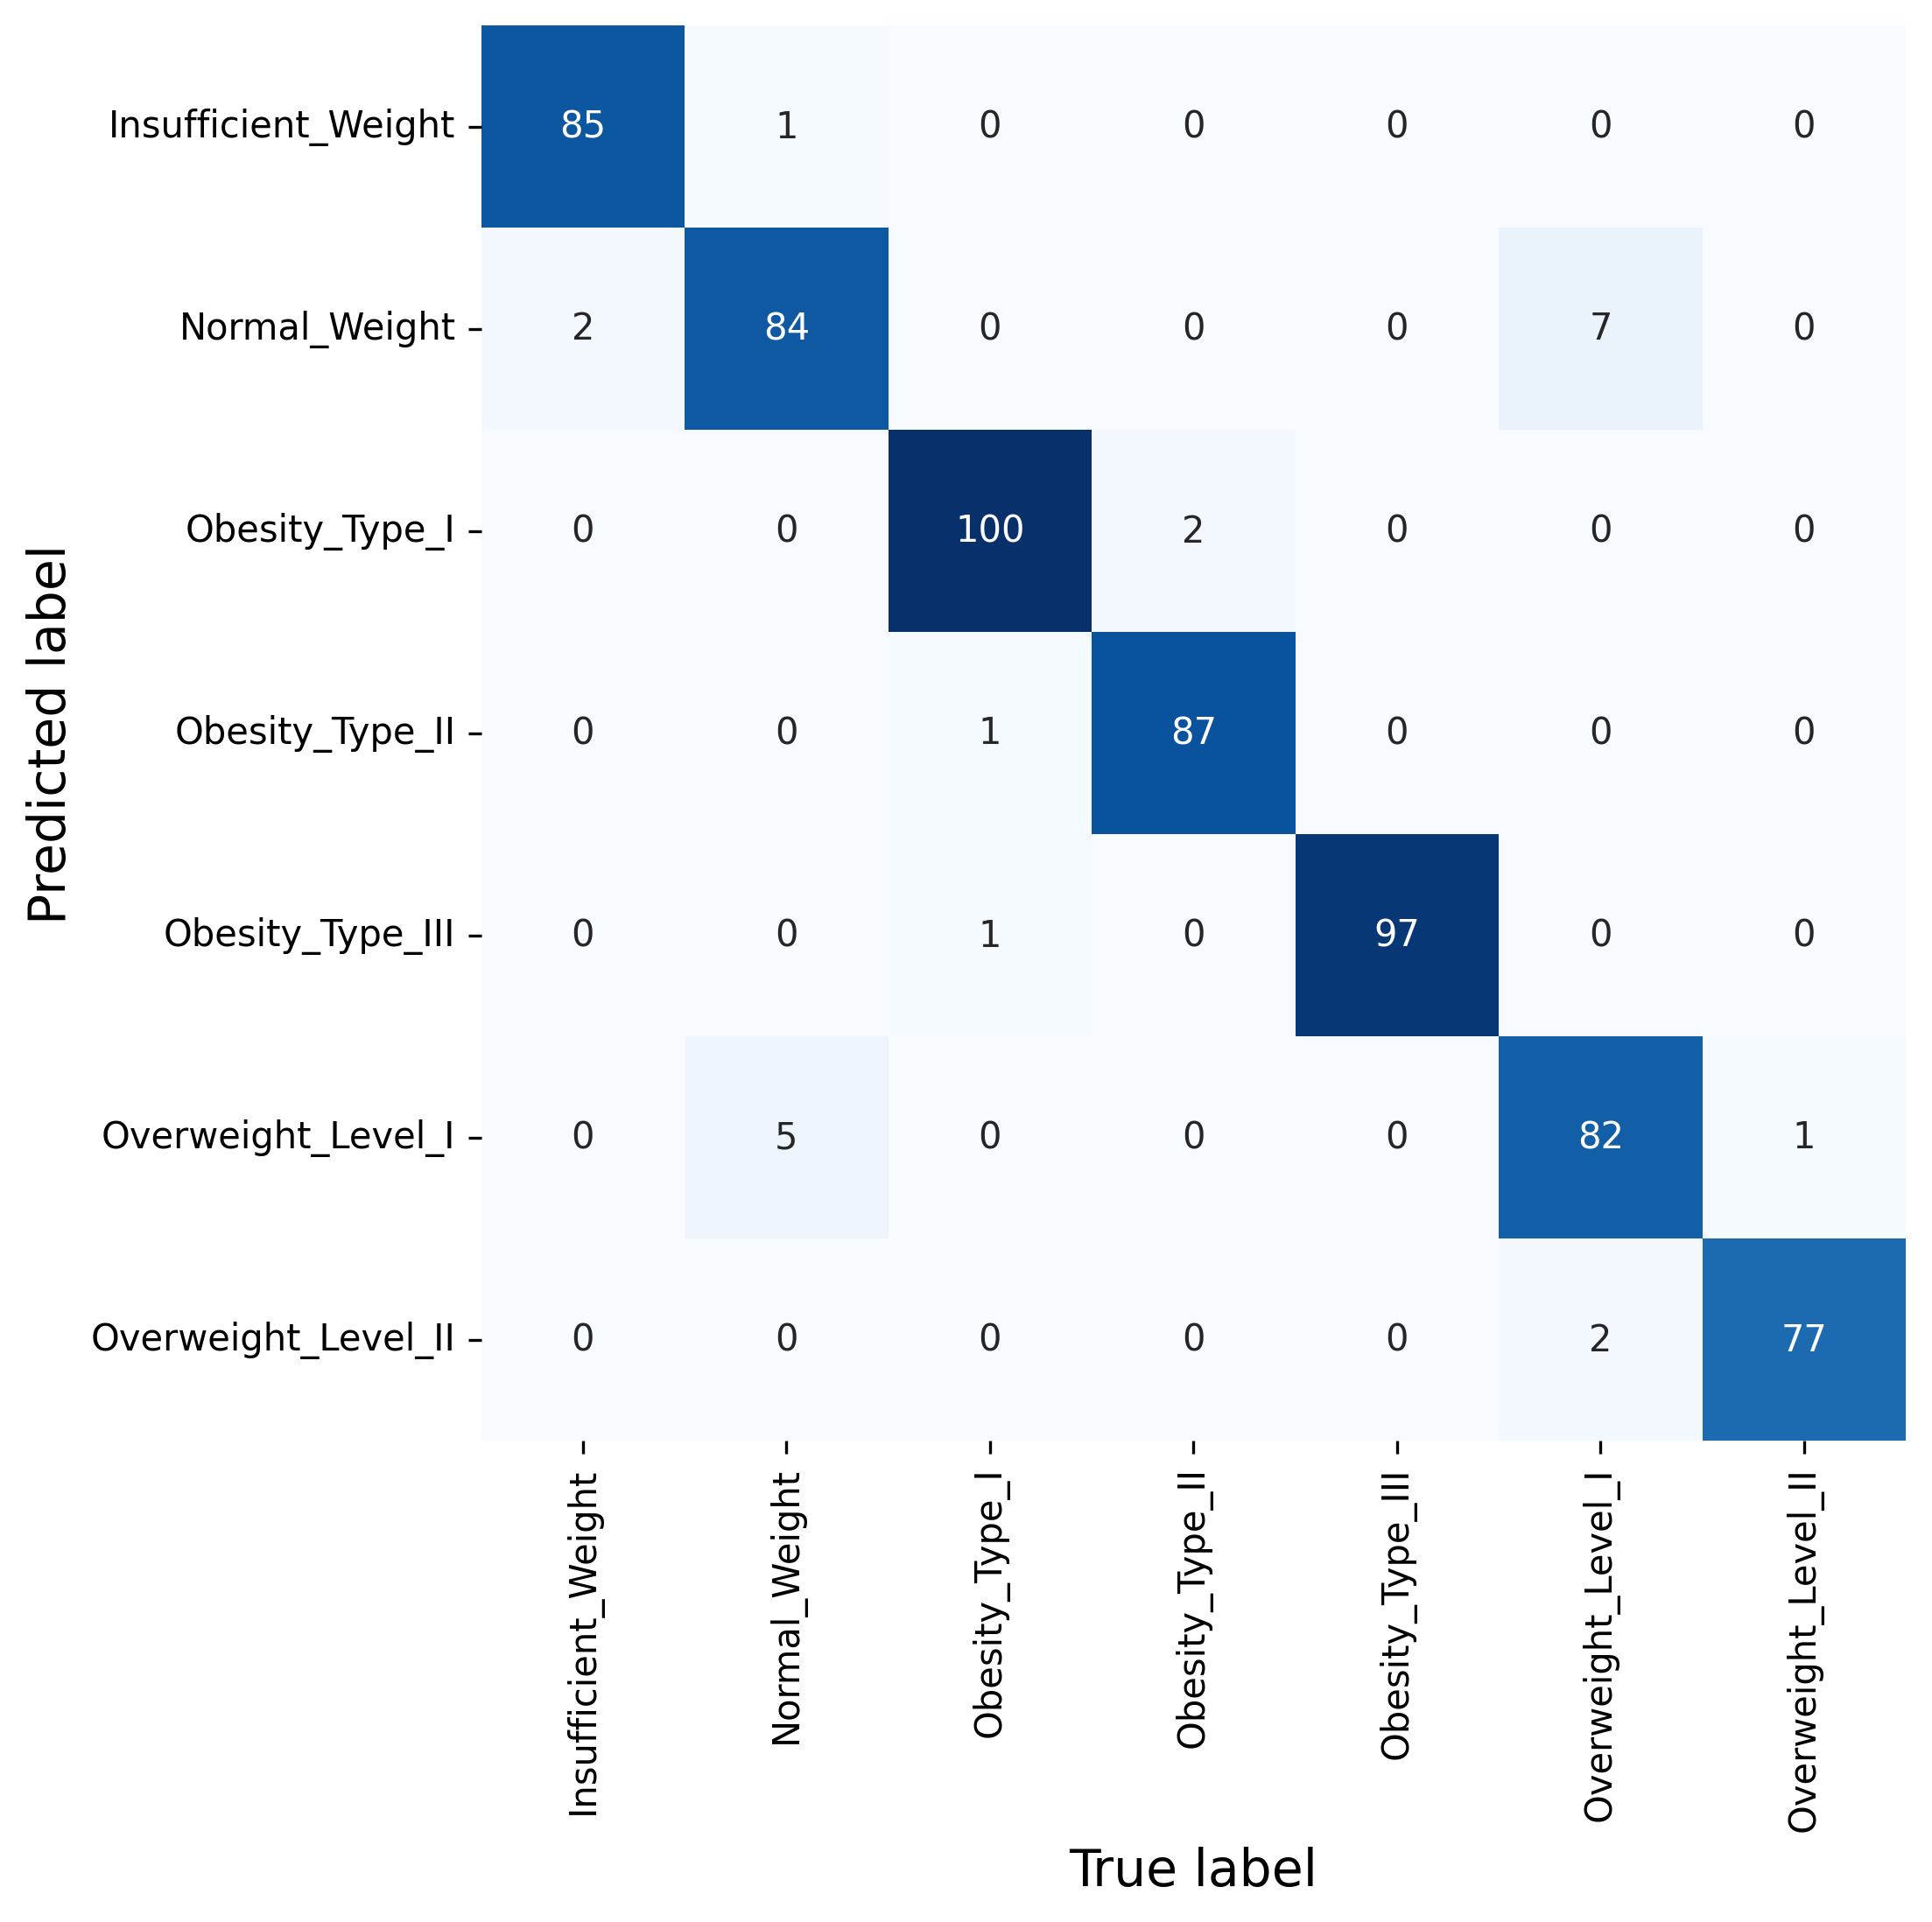

In [38]:
from sklearn.metrics import confusion_matrix

fig, ax = plt.subplots(figsize=(7, 7), dpi=300)

sb.heatmap(confusion_matrix(y_test, y_pred),
           annot=True, cmap="Blues", cbar=False, fmt=".0f",
           xticklabels=ada_clf.classes_,
           yticklabels=ada_clf.classes_)
ax.set_xlabel("True label", fontsize=14)
ax.set_ylabel("Predicted label", fontsize=14)
plt.show()

In many cases, ensemble models outperform individual models when it comes to robustness and the quality of the predictions. They come with two downsides. Firstly, they require the training and internal handling of dozens or hundreds of models instead of only one. For moderately sized datasets this is usually a price people are very willing to pay.

Secondly, ensemble models are often harder to interpret. An individual decision tree is, in principle, fully human-readable. However, a random forest of hundreds of trees is not as easily accessible. There are techniques that help us to interpret predictions of such ensemble models, such as SHAP {cite}`lundberg_shap2017` {cite}`lundberg2020local2global`. Feel free to explore those tools yourself (e.g. [SHAP](https://github.com/shap/shap)).

## Outlook: More on Machine Learning

This course is meant as a general introduction to data science. Machine Learning is, no doubt, one of the most essential tools for any data scientist to know about. In fact, it is not just one tool but an entire toolbox full of very powerful methods. It is important to know at least common examples of the most prominent types of tools, including unsupervised methods such as clustering techniques and dimensionality reduction, as well as supervised methods like k-nearest neighbors, linear regression, or decision trees.

However, this will just give you a first impression of what is possible with machine learning. In addition, we will focus on a basic intuition and first application of these methods. We will not cover all algorithms in full depth.

To deepen your understanding of individual methods and broaden your knowledge on various techniques, you might want to explore further. This includes the large field of deep learning, which we cannot cover in this course.

### Further Learning Resources

**Online courses and tutorials:**  
There are many, in fact probably too many, courses and tutorials out there. One of them that is clearly a long time recommendation is Andrew Ng's open online courses such as the [Machine Learning Introduction on coursera](https://www.coursera.org/specializations/machine-learning-introduction).

**Books on Machine Learning and Deep Learning:**  
- "Machine Learning with PyTorch and Scikit-Learn: Develop machine learning and deep learning models with Python" {cite}`raschka2022machine`
- "Understanding Deep Learning" by Simon Prince, MIT Press, 2023 {cite}`prince2023understanding`

By continuing to explore these resources, you can build a solid foundation in machine learning and stay up-to-date with the latest advancements in the field.

Happy (machine) learning!